# Important installation

This notebook requires unusual packages: `LightGBM`, `SHAP` and `LIME`. 
For installation, do:

`conda install lightgbm lime shap`
## Initial classical imports

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read in data
The stock data first:

In [2]:
dfs = {}

for ticker in ['BLK', 'GS', 'MS']:
    dfs[ticker] = pd.read_pickle('stock_{}.pickle'.format(ticker)).set_index('Date')

The media data:

In [3]:
df_media = pd.read_csv('MediaAttention_Mini.csv', parse_dates=[0], index_col='Time')

In [4]:
df_media.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4556 entries, 2005-07-22 to 2018-01-10
Data columns (total 23 columns):
Morgan_Stanley_count             4556 non-null int64
Goldman_Sachs_count              4556 non-null int64
BlackRock_count                  4556 non-null int64
positive_count                   4556 non-null int64
negative_count                   4556 non-null int64
Morgan_Stanley_positive_count    4556 non-null int64
Morgan_Stanley_negative_count    4556 non-null int64
Goldman_Sachs_positive_count     4556 non-null int64
Goldman_Sachs_negative_count     4556 non-null int64
BlackRock_positive_count         4556 non-null int64
BlackRock_negative_count         4556 non-null int64
total_msg_count                  4556 non-null int64
Morgan_Stanley_frac              3439 non-null float64
Goldman_Sachs_frac               3439 non-null float64
BlackRock_frac                   3439 non-null float64
positive_frac                    3439 non-null float64
negative_frac      

In [5]:
import glob
df_media_long = pd.DataFrame()
for fle in glob.glob('MediaAttentionLong*.csv'):
    dummy = pd.read_csv(fle, parse_dates=[0], index_col='Time')
    df_media_long =  pd.concat([df_media_long,dummy])
              
df_media_long = df_media_long['2007':'2015']
df_media_long = df_media_long.resample('1D').sum()
df_media_long.shape

(3283, 23)

In [6]:
#df_media_long= pd.read_csv('MediaAttentionLong_2008.csv', parse_dates=[0], index_col='Time')

In [7]:
df_media_long.columns = ['{}_Long'.format(c) for c in df_media_long.columns]

In [8]:
df_media_long.loc['2008',:].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2008-01-01 to 2008-12-31
Freq: D
Data columns (total 23 columns):
Morgan_Stanley_count_Long             366 non-null int64
Goldman_Sachs_count_Long              366 non-null int64
BlackRock_count_Long                  366 non-null int64
positive_count_Long                   366 non-null int64
negative_count_Long                   366 non-null int64
Morgan_Stanley_positive_count_Long    366 non-null int64
Morgan_Stanley_negative_count_Long    366 non-null int64
Goldman_Sachs_positive_count_Long     366 non-null int64
Goldman_Sachs_negative_count_Long     366 non-null int64
BlackRock_positive_count_Long         366 non-null int64
BlackRock_negative_count_Long         366 non-null int64
total_msg_count_Long                  366 non-null int64
Morgan_Stanley_frac_Long              366 non-null float64
Goldman_Sachs_frac_Long               366 non-null float64
BlackRock_frac_Long                   366 non-null float64
positiv

In [9]:
for ticker in dfs:
    dfs[ticker] = dfs[ticker].merge(df_media, how='inner', left_index=True, right_index=True)
    dfs[ticker] = dfs[ticker].merge(df_media_long, how='inner', left_index=True, right_index=True)

In [10]:
dfs['BLK'].head(10)

,Close,diff_1d,diff_7d,Label,Morgan_Stanley_count,Goldman_Sachs_count,BlackRock_count,positive_count,negative_count,Morgan_Stanley_positive_count,...,Goldman_Sachs_frac_Long,BlackRock_frac_Long,positive_frac_Long,negative_frac_Long,Morgan_Stanley_positive_frac_Long,Morgan_Stanley_negative_frac_Long,Goldman_Sachs_positive_frac_Long,Goldman_Sachs_negative_frac_Long,BlackRock_positive_frac_Long,BlackRock_negative_frac_Long
2007-01-03,155.119995,NaN,NaN,0,2,2,0,86,210,0,...,0.028846,0.000000,2.706731,2.312500,0.083333,0.232372,0.064103,0.054487,0.0,0.0
2007-01-04,156.789993,NaN,NaN,1,1,0,0,133,252,0,...,0.021362,0.000000,2.352470,2.125501,0.102804,0.104139,0.072096,0.017356,0.0,0.0
2007-01-05,156.750000,0.010766,NaN,0,1,0,0,100,259,0,...,0.024060,0.000000,3.106767,2.666165,0.075188,0.058647,0.109774,0.079699,0.0,0.0
2007-01-08,159.639999,-0.000255,NaN,1,3,3,0,147,315,0,...,0.077273,0.000000,2.622727,2.180682,0.026136,0.056818,0.245455,0.215909,0.0,0.0
2007-01-09,160.649994,0.018437,NaN,1,0,1,0,119,357,0,...,0.032597,0.000000,2.507886,2.359621,0.087277,0.058885,0.126183,0.110410,0.0,0.0
2007-01-10,164.899994,0.006327,NaN,1,1,2,0,112,393,0,...,0.039474,0.001012,2.461538,2.305668,0.119433,0.093117,0.260121,0.081984,0.0,0.0
2007-01-11,168.020004,0.026455,NaN,1,2,0,0,117,423,0,...,0.024974,0.000000,2.560874,2.325702,0.064516,0.042664,0.115505,0.049948,0.0,0.0
2007-01-12,172.500000,0.018921,NaN,1,0,0,0,92,377,0,...,0.023068,0.000000,3.881200,5.378316,0.032295,0.021915,0.116494,0.077278,0.0,0.0
2007-01-16,171.460007,0.026663,0.015331,0,0,1,0,141,385,0,...,0.028272,0.000000,5.421990,9.296335,0.063874,0.033508,0.128796,0.100524,0.0,0.0
2007-01-17,173.190002,-0.006029,0.012931,1,6,2,0,129,471,0,...,0.044964,0.000000,2.631295,2.293165,0.048561,0.065647,0.142986,0.091727,0.0,0.0


# Model

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, make_scorer
from sklearn.model_selection import  cross_val_score, KFold

/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [12]:
model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=314, n_jobs=4)

In [13]:
for ticker in dfs:
    X = dfs[ticker].drop(['Label', 'Close'], axis=1).fillna(-1)
    y = dfs[ticker].loc[:,'Label']
    scores = cross_val_score(model, X, y, 
                             scoring=make_scorer(accuracy_score), 
                             cv=KFold(10, shuffle=True, random_state=314), 
                             n_jobs=1
                            )
    print('{} prediction performance in accuracy = {:.3f}+-{:.3f}'.format(ticker,
                                                                          np.mean(scores),
                                                                          np.std(scores)
                                                                         ))

BLK prediction performance in accuracy = 0.511+-0.033
GS prediction performance in accuracy = 0.511+-0.037
MS prediction performance in accuracy = 0.511+-0.031


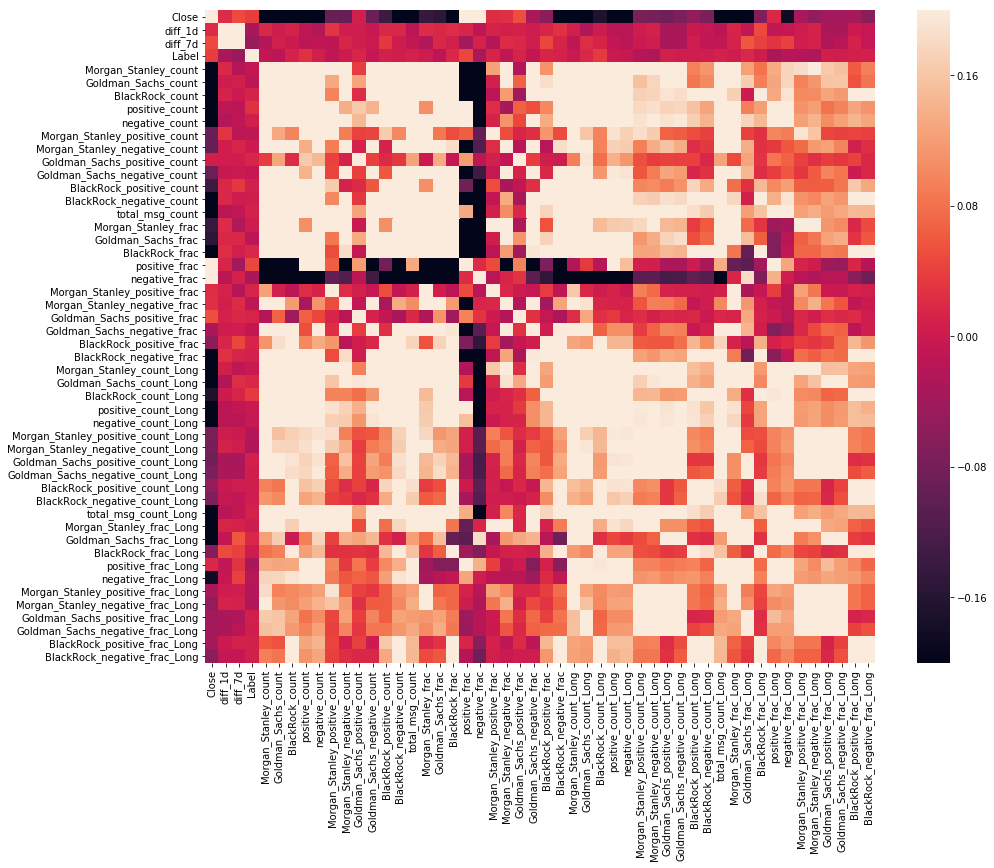

In [14]:
plt.figure(figsize=(15,12))
sns.heatmap(dfs['BLK'].corr(), vmin=-0.2, vmax=0.2)

### Train a model on all data

In [15]:
    df = pd.concat(list(dfs.values()), axis=0)
    X = df.drop(['Label', 'Close'], axis=1).fillna(-1)
    y = df.loc[:,'Label']
    scores = cross_val_score(model, X, y, 
                             scoring=make_scorer(accuracy_score), 
                             cv=KFold(10, shuffle=True, random_state=314), 
                             n_jobs=1
                            )
    print('{} prediction performance in accuracy = {:.3f}+-{:.3f}'.format('ALL',
                                                                          np.mean(scores),
                                                                          np.std(scores)
                                                                         ))

ALL prediction performance in accuracy = 0.568+-0.022


In [16]:
scores

array([0.56848306, 0.59351988, 0.55670103, 0.58762887, 0.57731959,
       0.59057437, 0.54424779, 0.51917404, 0.56342183, 0.57964602])

In [17]:
mdl = model.fit(X,y)

In [18]:
import shap
shap.initjs()

In [19]:
explainer=shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(X)

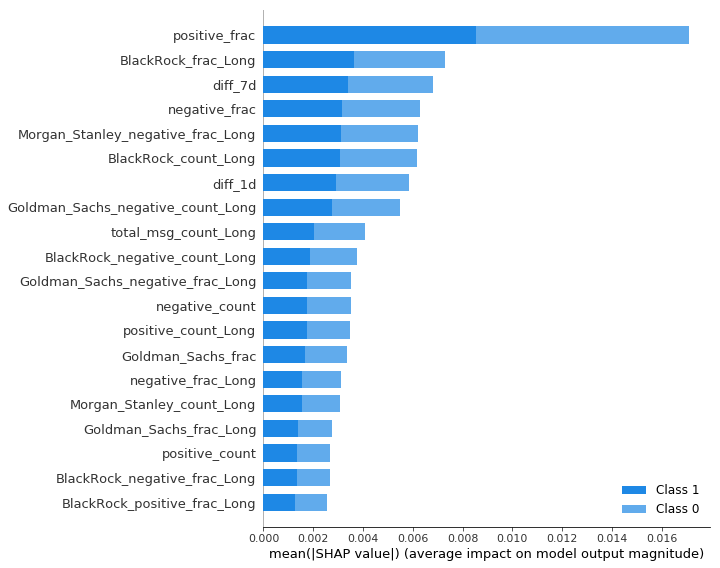

In [20]:
shap.summary_plot(shap_values, X, plot_type="bar")

## LightGBM

In [21]:
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.base import clone, ClassifierMixin, RegressorMixin
import lightgbm as lgb


def train_single_model(clf_, X_, y_, random_state_=314, opt_parameters_={}, fit_params_={}):
    '''
    A wrapper to train a model with particular parameters
    '''
    c = clone(clf_)
    c.set_params(**opt_parameters_)
    c.set_params(random_state=random_state_)
    return c.fit(X_, y_, **fit_params_)

def train_model_in_CV(model, X, y, metric, metric_args={},
                            model_name='xmodel',
                            seed=31416, n=5,
                            opt_parameters_={}, fit_params_={},
                            verbose=True,
                            groups=None, y_eval=None):
    # the list of classifiers for voting ensable
    clfs = []
    # performance 
    perf_eval = {'score_i_oof': 0,
                 'score_i_ave': 0,
                 'score_i_std': 0,
                 'score_i': []
                }
    # full-sample oof prediction
    y_full_oof = pd.Series(np.zeros(shape=(y.shape[0],)), 
                          index=y.index)
    
    sample_weight=None
    if 'sample_weight' in metric_args:
        sample_weight=metric_args['sample_weight']
        
    index_weight=None
    if 'index_weight' in metric_args:
        index_weight=metric_args['index_weight']
        del metric_args['index_weight']
        
    doSqrt=False
    if 'sqrt' in metric_args:
        doSqrt=True
        del metric_args['sqrt']

    if groups is None:
        cv = KFold(n, shuffle=True, random_state=seed) #Stratified
    else:
        cv = GroupKFold(n)
    # The out-of-fold (oof) prediction for the k-1 sample in the outer CV loop
    y_oof = pd.Series(np.zeros(shape=(X.shape[0],)), 
                      index=X.index)
    scores = []
    clfs = []

    for n_fold, (trn_idx, val_idx) in enumerate(cv.split(X, (y!=0).astype(np.int8), groups=groups)):
        X_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        if 'LGBMRanker' in type(model).__name__ and groups is not None:
            G_trn, G_val = groups.iloc[trn_idx], groups.iloc[val_idx]        

        if fit_params_:
            # use _stp data for early stopping
            fit_params_["eval_set"] = [(X_trn,y_trn), (X_val,y_val)]
            fit_params_['verbose'] = verbose
            if index_weight is not None:
                fit_params_["sample_weight"] = y_trn.index.map(index_weight).values
                fit_params_["eval_sample_weight"] = [None, y_val.index.map(index_weight).values]
            if 'LGBMRanker' in type(model).__name__ and groups is not None:
                fit_params_['group'] = G_trn.groupby(G_trn, sort=False).count()
                fit_params_['eval_group'] = [G_trn.groupby(G_trn, sort=False).count(),
                                             G_val.groupby(G_val, sort=False).count()]

        #display(y_trn.head())
        clf = train_single_model(model, X_trn, y_trn, 314+n_fold, opt_parameters_, fit_params_)

        clfs.append(('{}{}'.format(model_name,n_fold), clf))
        # oof predictions
        if isinstance(clf, RegressorMixin):
            y_oof.iloc[val_idx] = clf.predict(X_val)
        elif isinstance(clf, ClassifierMixin) and metric.__name__=='roc_auc_score':
            y_oof.iloc[val_idx] = clf.predict_proba(X_val)[:,1]
        else:
            y_oof.iloc[val_idx] = clf.predict(X_val)
        # prepare weights for evaluation
        if sample_weight is not None:
            metric_args['sample_weight'] = y_val.map(sample_weight)
        elif index_weight is not None:
            metric_args['sample_weight'] = y_val.index.map(index_weight).values
        # prepare target values
        y_true_tmp = y_val if 'LGBMRanker' not in type(model).__name__  and y_eval is None else y_eval.iloc[val_idx]
        y_pred_tmp = y_oof.iloc[val_idx] if y_eval is None else y_oof.iloc[val_idx]        
        #store evaluated metric
        scores.append(metric(y_true_tmp, y_pred_tmp, **metric_args))
        #cleanup
        del X_trn, y_trn, X_val, y_val, y_true_tmp, y_pred_tmp

    # Store performance info for this CV
    if sample_weight is not None:
        metric_args['sample_weight'] = y_oof.map(sample_weight)
    elif index_weight is not None:
        metric_args['sample_weight'] = y_oof.index.map(index_weight).values
    perf_eval['score_i_oof'] = metric(y, y_oof, **metric_args)
    perf_eval['score_i'] = scores
    
    if doSqrt:
        for k in perf_eval.keys():
            if 'score' in k:
                perf_eval[k] = np.sqrt(perf_eval[k])
        scores = np.sqrt(scores)
            
    perf_eval['score_i_ave'] = np.mean(scores)
    perf_eval['score_i_std'] = np.std(scores)

    return clfs, perf_eval, y_oof

def print_perf_clf(name, perf_eval):
    print('Performance of the model:')    
    print('Mean(Val) score inner {} Classifier: {:.4f}+-{:.4f}'.format(name, 
                                                                      perf_eval['score_i_ave'],
                                                                      perf_eval['score_i_std']
                                                                     ))
    print('Min/max scores on folds: {:.4f} / {:.4f}'.format(np.min(perf_eval['score_i']),
                                                            np.max(perf_eval['score_i'])))
    print('OOF score inner {} Classifier: {:.4f}'.format(name, perf_eval['score_i_oof']))
    print('Scores in individual folds: {}'.format(perf_eval['score_i']))





In [22]:
mdl_inputs = {
        'lgbm1_reg': (lgb.LGBMClassifier(max_depth=-1, min_child_samples=400, random_state=314, silent=True, metric='None', 
                                        n_jobs=4, n_estimators=1000, learning_rate=0.1),
                 {'colsample_bytree': 0.9, 'min_child_weight': 10.0, 'num_leaves': 20, 'reg_alpha': 1, 'subsample': 0.9}, 
                 {"early_stopping_rounds":20, 
                  "eval_metric" : 'binary_logloss',
                  'eval_names': ['train', 'early_stop'],
                  'verbose': False, 
                  #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_decay_power)],
                 },#'categorical_feature': 'auto'},
                 y,
                 None
                ),
        'rf1': (
            RandomForestClassifier(n_estimators=100, max_depth=4, random_state=314, n_jobs=4),
            {},
            {},
            y,
            None
        )
}

In [23]:
%%time
mdls = {}
results = {}
y_oofs = {}
for name, (mdl, mdl_pars, fit_pars, y_, g_) in mdl_inputs.items():
    print('--------------- {} -----------'.format(name))
    mdl_, perf_eval_, y_oof_ = train_model_in_CV(mdl, X, y_, accuracy_score, 
                                                          metric_args={},
                                                          model_name=name, 
                                                          opt_parameters_=mdl_pars,
                                                          fit_params_=fit_pars, 
                                                          n=10, seed=3146,
                                                          verbose=500, 
                                                          groups=g_)
    results[name] = perf_eval_
    mdls[name] = mdl_
    y_oofs[name] = y_oof_
    print_perf_clf(name, perf_eval_)



--------------- lgbm1_reg -----------
Training until validation scores don't improve for 20 rounds.
[500]	train's binary_logloss: 0.428957	early_stop's binary_logloss: 0.604011
Early stopping, best iteration is:
[520]	train's binary_logloss: 0.424355	early_stop's binary_logloss: 0.601356
Training until validation scores don't improve for 20 rounds.


/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Early stopping, best iteration is:
[476]	train's binary_logloss: 0.435866	early_stop's binary_logloss: 0.584097
Training until validation scores don't improve for 20 rounds.


/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Early stopping, best iteration is:
[398]	train's binary_logloss: 0.45314	early_stop's binary_logloss: 0.633684
Training until validation scores don't improve for 20 rounds.


/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[500]	train's binary_logloss: 0.427289	early_stop's binary_logloss: 0.607699
Early stopping, best iteration is:
[498]	train's binary_logloss: 0.427692	early_stop's binary_logloss: 0.607377
Training until validation scores don't improve for 20 rounds.


/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[500]	train's binary_logloss: 0.429682	early_stop's binary_logloss: 0.598566
Early stopping, best iteration is:
[486]	train's binary_logloss: 0.433181	early_stop's binary_logloss: 0.598092
Training until validation scores don't improve for 20 rounds.


/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[500]	train's binary_logloss: 0.427788	early_stop's binary_logloss: 0.600625
Early stopping, best iteration is:
[533]	train's binary_logloss: 0.419946	early_stop's binary_logloss: 0.599346
Training until validation scores don't improve for 20 rounds.


/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[500]	train's binary_logloss: 0.429973	early_stop's binary_logloss: 0.585405
Early stopping, best iteration is:
[816]	train's binary_logloss: 0.368817	early_stop's binary_logloss: 0.561934
Training until validation scores don't improve for 20 rounds.


/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[500]	train's binary_logloss: 0.428532	early_stop's binary_logloss: 0.594653
Early stopping, best iteration is:
[565]	train's binary_logloss: 0.413013	early_stop's binary_logloss: 0.59162
Training until validation scores don't improve for 20 rounds.


/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[500]	train's binary_logloss: 0.424091	early_stop's binary_logloss: 0.609562
Early stopping, best iteration is:
[558]	train's binary_logloss: 0.410711	early_stop's binary_logloss: 0.606865
Training until validation scores don't improve for 20 rounds.


/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[500]	train's binary_logloss: 0.425905	early_stop's binary_logloss: 0.60887
Early stopping, best iteration is:
[526]	train's binary_logloss: 0.419688	early_stop's binary_logloss: 0.605644
Performance of the model:
Mean(Val) score inner lgbm1_reg Classifier: 0.6894+-0.0193
Min/max scores on folds: 0.6657 / 0.7275
OOF score inner lgbm1_reg Classifier: 0.6894
Scores in individual folds: [0.6715758468335787, 0.727540500736377, 0.6656848306332842, 0.6671575846833578, 0.695139911634757, 0.7010309278350515, 0.7138643067846607, 0.6887905604719764, 0.6814159292035398, 0.6814159292035398]
--------------- rf1 -----------


/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Performance of the model:
Mean(Val) score inner rf1 Classifier: 0.5704+-0.0209
Min/max scores on folds: 0.5346 / 0.5988
OOF score inner rf1 Classifier: 0.5704
Scores in individual folds: [0.5964653902798233, 0.5891016200294551, 0.5346097201767305, 0.5537555228276878, 0.5743740795287187, 0.5846833578792342, 0.5619469026548672, 0.5988200589970502, 0.5442477876106194, 0.5663716814159292]
CPU times: user 41.5 s, sys: 253 ms, total: 41.8 s
Wall time: 12.6 s


# Train LGBM model on a simple rain/val/test split (70/15/15)

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
# X = dfs['MS'].drop(['Label', 'Close'], axis=1).fillna(-1)
# y = dfs['MS'].loc[:,'Label']

In [26]:
X_1,   X_tst, y_1,   y_tst = train_test_split(X['2007':'2015'],   y['2007':'2015'],   test_size=0.15, shuffle=True, random_state=314)
X_trn, X_val, y_trn, y_val = train_test_split(X_1, y_1, test_size=0.15, shuffle=True, random_state=31)

In [27]:
mdl = lgb.LGBMClassifier(max_depth=-1, min_child_samples=400, random_state=314,
                   silent=True, metric='None', 
                   n_jobs=4, n_estimators=1000, learning_rate=0.1,
                   **{'colsample_bytree': 0.9, 'min_child_weight': 10.0, 'num_leaves': 20, 'reg_alpha': 1, 'subsample': 0.9}
                        )

In [28]:
mdl.fit(X_trn, y_trn, 
        **{"early_stopping_rounds":20, 
           "eval_metric" : 'binary_logloss',
           'eval_set': [(X_trn, y_trn), (X_val, y_val)],
           'eval_names': ['train', 'early_stop'],
           'verbose': 100
    })

Training until validation scores don't improve for 20 rounds.
[100]	train's binary_logloss: 0.599271	early_stop's binary_logloss: 0.669477
[200]	train's binary_logloss: 0.546314	early_stop's binary_logloss: 0.653085
[300]	train's binary_logloss: 0.506928	early_stop's binary_logloss: 0.642385
Early stopping, best iteration is:
[297]	train's binary_logloss: 0.508007	early_stop's binary_logloss: 0.641723


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        metric='None', min_child_samples=400, min_child_weight=10.0,
        min_split_gain=0.0, n_estimators=1000, n_jobs=4, num_leaves=20,
        objective=None, random_state=314, reg_alpha=1, reg_lambda=0.0,
        silent=True, subsample=0.9, subsample_for_bin=200000,
        subsample_freq=0)

In [29]:
print('Accuracy score on train/validation/test samples is: {:.3f}/{:.3f}/{:.3f}'.format(accuracy_score(y_trn, mdl.predict(X_trn)),
                                                                            accuracy_score(y_val, mdl.predict(X_val)),
                                                                            accuracy_score(y_tst, mdl.predict(X_tst))
                                                                           ))

Accuracy score on train/validation/test samples is: 0.806/0.641/0.632


/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Do LGBM model exlanation
### SHAP

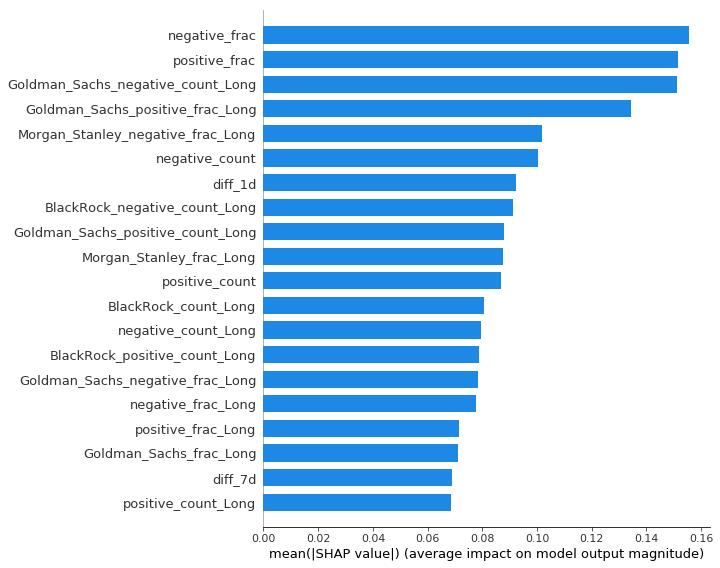

In [30]:
explainer=shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(X_tst)
shap.summary_plot(shap_values, X_tst, plot_type="bar")

_To understand how a single feature effects the output of the model we can plot **the SHAP value of that feature vs. the value of the feature** for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, **the plot below represents the change in predicted label as either of chosen variables changes**._

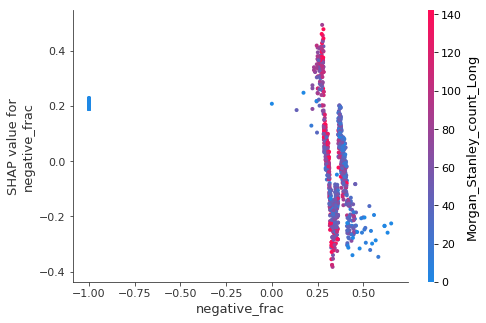

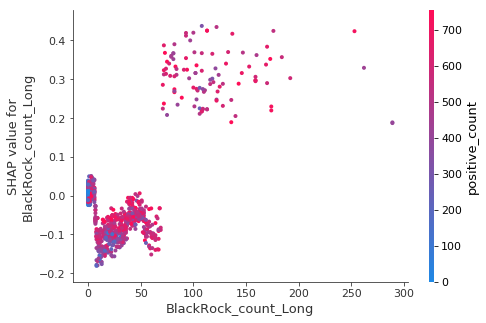

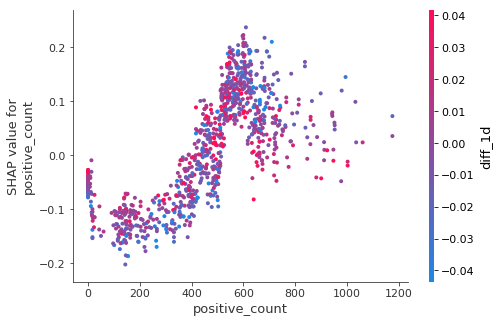

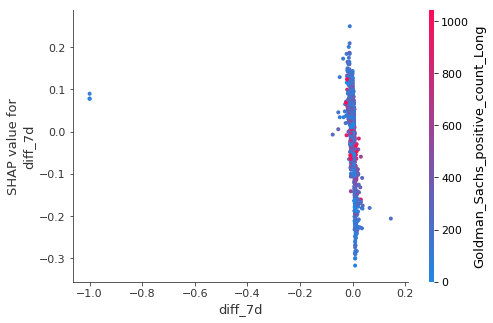

In [31]:
for f in ['negative_frac', 'BlackRock_count_Long', 'positive_count', 'diff_7d']:
    shap.dependence_plot(f, shap_values, X_tst)

### LIME

In [32]:
import lime
from  lime.lime_tabular import LimeTabularExplainer

In [33]:
explainer = LimeTabularExplainer(X_trn.values, 
                                 feature_names=X_trn.columns, 
                                 class_names=['Down','Up'], 
                                 verbose=False, 
                                 mode='classification')

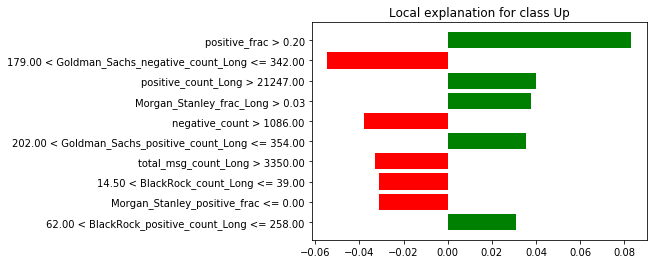

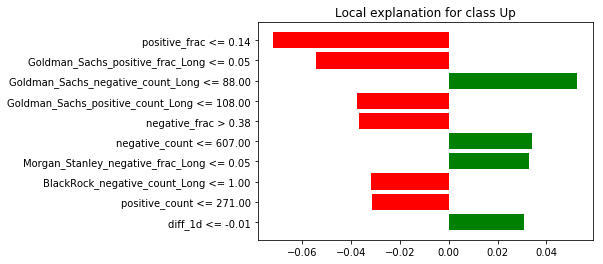

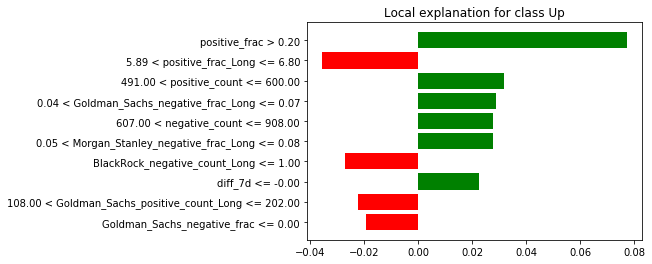

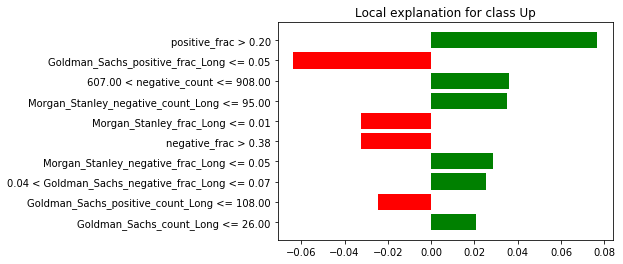

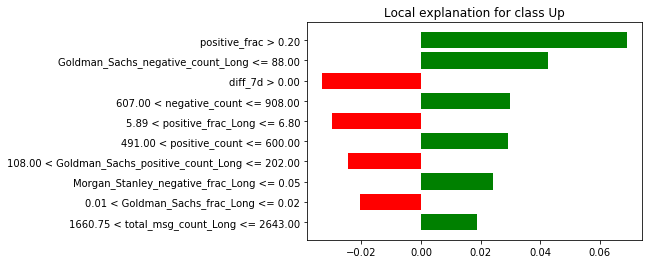

In [34]:
exp= []
for i in range(5):
    e = explainer.explain_instance(X_trn.iloc[i,:].values, mdl.predict_proba)
    _ = e.as_pyplot_figure(label=1)
    #exp.append(e)

In [35]:
import pickle

In [36]:
with open('model_lighgbm.pkl', 'wb') as fout:
    pickle.dump(mdl, fout)

## Simulation

In [37]:
def buy(stockV, money, transCost):
    stockN = (money - transCost)/stockV 
    return stockN 

def sell(stockV, stockN, transCost):
    money = stockN * stockV - transCost
    return money
    
def stockMoney(stockV, stockN):
    money = stockV * stockN
    return money

def play_stock_market(compTick_, dfs, ncalls=100, mdl_=None):
    df_stock = dfs[compTick_]
    money0 = 100000   # 
    transCost = 5 
    stockVal = df_stock['Close']
    
    moneyArr = np.zeros((df_stock.shape[0], ncalls))
    
    for i in range(ncalls):
        stockVal0 = stockVal[0]
        stockN0 = money0/stockVal0-transCost
        label0 = np.random.randint(2,size=1)

        stockN0 = buy(stockVal0, money0, transCost)
        #moneyArr = np.zeros(df_stock.shape[0]);

        haveStock = 0
        stockN = stockN0

        moneyNew = stockMoney(stockVal0, stockN0)
        moneyOld = stockMoney(stockVal0, stockN0)
        haveStock = 1
        
        if mdl_ is not None:
            predictions = mdl.predict(dfs[compTick_].drop(['Label', 'Close'], axis=1).fillna(-1))

        for kk,tStep in enumerate(df_stock.index):
            if mdl_ is not None:
                # model predictions
                labeldummy = predictions[kk]
            else:
                # random behaviour
                labeldummy = np.random.randint(2,size=1)
            #print(labeldummy)
            if labeldummy == 1:   # hold/ buy
                if haveStock == 1: # hold
                    moneyNew = stockMoney(stockVal[tStep], stockN)
                elif haveStock ==0:  # buy
                    stockN = buy(stockVal[tStep], moneyOld, transCost)
                    moneyNew = stockMoney(stockVal[tStep], stockN)
                    haveStock = 1

            if labeldummy == 0: 
                if haveStock == 1: # sell
                    moneyNew = sell(stockVal[tStep], stockN, transCost)
                    stockN = 0
                    haveStock = 0
                elif haveStock == 0:  # wait
                    moneyNew = moneyOld

            if moneyNew < 0:
                break
            moneyArr[kk,i] = moneyNew
            moneyOld = moneyNew 
            
    return moneyArr


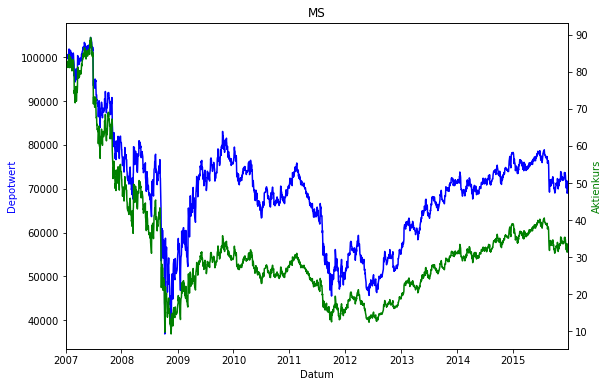

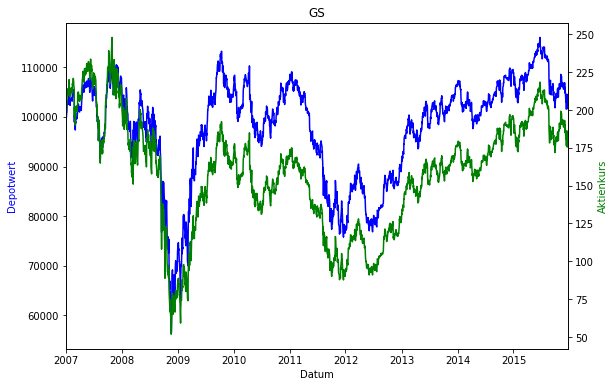

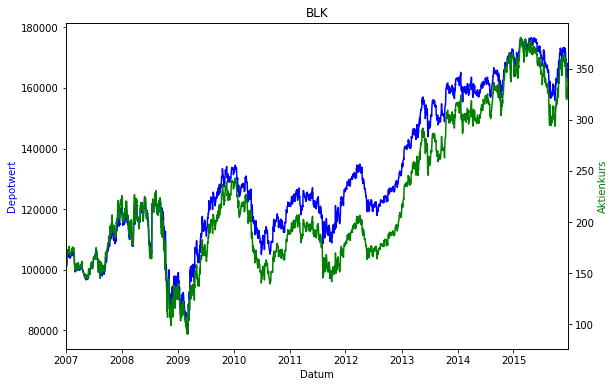

In [38]:
for compTick in ['MS', 'GS', "BLK"]:
    tmp = play_stock_market(compTick, dfs, 100)
    df_stock = dfs[compTick]
    datX = df_stock.index
    datZ = tmp.mean(axis=1)
    datZ2 = df_stock['Close']

    fig = plt.figure(figsize=(9,6))   # create a figure with specified size
    ax1 = fig.add_subplot(111)  
    ax1.plot(datX,datZ, '-b')
    ax1.set_xlim([datX[0], datX[-1]])
    ax1.set_xlabel('Datum')                                  # set x label
    #ax1.set_ylabel('Depotwert')

    ax3 = ax1.twinx()
    ax3.plot(datX,datZ2, '-g')
    ax3.set_ylabel('Aktienkurs', color='g')                  # set the right ordinate axes label
    #ax1.plot(datX,datZ, '-b')                          # replot in blue color which matches the z label to be able to discern the plots                
    ax1.set_ylabel('Depotwert', color='b')  
    plt.title(compTick)
    plt.show()

### Model-drivel trading

/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


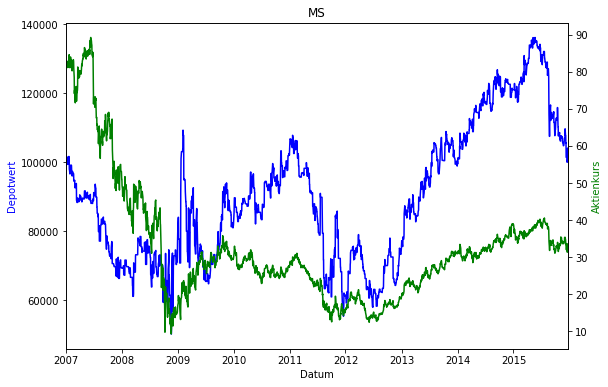

/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


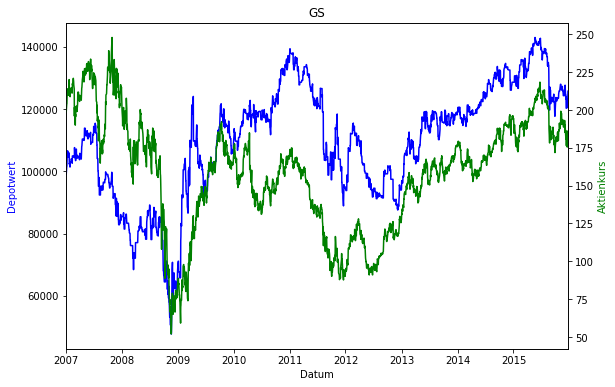

/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


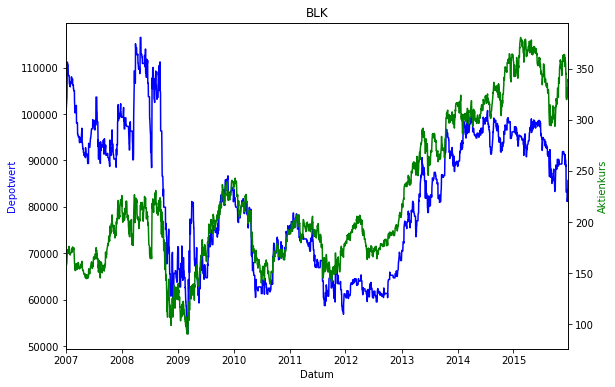

In [39]:
for compTick in ['MS', 'GS', "BLK"]:
    tmp = play_stock_market(compTick, dfs, 1, mdl_=mdl)
    df_stock = dfs[compTick]
    datX = df_stock.index
    datZ = tmp.mean(axis=1)
    datZ2 = df_stock['Close']

    fig = plt.figure(figsize=(9,6))   # create a figure with specified size
    ax1 = fig.add_subplot(111)  
    ax1.plot(datX,datZ, '-b')
    ax1.set_xlim([datX[0], datX[-1]])
    ax1.set_xlabel('Datum')                                  # set x label
    #ax1.set_ylabel('Geld')

    ax3 = ax1.twinx()
    ax3.plot(datX,datZ2, '-g')
    ax3.set_ylabel('Aktienkurs', color='g')                  # set the right ordinate axes label
    #ax1.plot(datX,datZ, '-b')                          # replot in blue color which matches the z label to be able to discern the plots                
    ax1.set_ylabel('Depotwert', color='b')  
    plt.title(compTick)
    plt.show()

In [40]:
predictions1 = mdl.predict(dfs['MS'].drop(['Label', 'Close'], axis=1).fillna(-1))

/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [41]:
predictions2 = mdl.predict(dfs['GS'].drop(['Label', 'Close'], axis=1).fillna(-1))

/home/mlisovyi/Drive/anaconda3/envs/dfine_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [42]:
(predictions1 != predictions2).sum()

170